This notebook organizes the pathways level information to compare human to microbial pathways.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graph-layout" data-toc-modified-id="Graph-layout-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graph layout</a></span></li><li><span><a href="#Color-compounds-by-omics-level-and-pvalue" data-toc-modified-id="Color-compounds-by-omics-level-and-pvalue-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Color compounds by omics level and pvalue</a></span></li><li><span><a href="#Big-venn-diagram" data-toc-modified-id="Big-venn-diagram-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Big venn diagram</a></span></li><li><span><a href="#Network-plot" data-toc-modified-id="Network-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network plot</a></span></li></ul></div>

In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import networkx as nx
import seaborn as sns
import matplotlib as mpl

from matplotlib_venn import venn2, venn3
%matplotlib inline

np.random.seed(0)

In [2]:
rna_edges = pd.read_parquet('../results/rna_compound_edges.parquet')
wgs_edges = pd.read_parquet('../results/wgs_compound_edges.parquet')
amp_edges = pd.read_parquet('../results/amp_compound_edges.parquet')

In [3]:
edges = pd.concat((wgs_edges, amp_edges, rna_edges))
edges = edges.drop_duplicates()

In [4]:
graph = nx.from_pandas_edgelist(edges, 'src', 'dest')

In [5]:
nx.number_connected_components(graph)

2

In [6]:
components = nx.connected_components(graph)

In [7]:
for c in components:
    print('Nodes', len(c))

Nodes 5412
Nodes 64


# Graph layout

In [8]:
components = nx.connected_components(graph)
comp = next(components) # get first component, since it is the largest

In [9]:
#pos.loc[list(comp)].to_csv('../results/connected_compound_positions.csv')
pos = pd.read_csv('../results/compound_positions.csv', index_col=0)

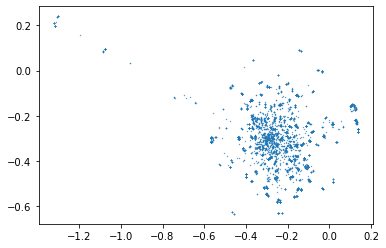

In [10]:
cpos = pos.loc[list(comp)]
epos = pos.loc[list(set(pos.index) - comp)]
k = 4
off = 0.3
cpos = cpos * k - off
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

In [11]:
#new_pos = pd.concat((cpos, epos))
new_pos = cpos

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


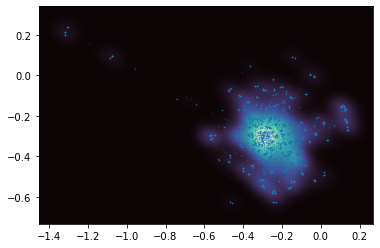

In [12]:
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100)
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1, alpha=0.5)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

# Color compounds by omics level and pvalue

In [13]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
#wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

In [14]:
rna_logpvals = rna_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
#wgs_logpvals = wgs_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
amp_logpvals = amp_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()

In [15]:
#wgs_pos = pd.merge(new_pos, wgs_logpvals, left_index=True, right_index=True)
amp_pos = pd.merge(new_pos, amp_logpvals, left_index=True, right_index=True)
rna_pos = pd.merge(new_pos, rna_logpvals, left_index=True, right_index=True)

In [16]:
micro = amp_pos
new_pos = pd.concat((amp_pos, rna_pos))

<AxesSubplot:xlabel='-log(pvalue)', ylabel='Count'>

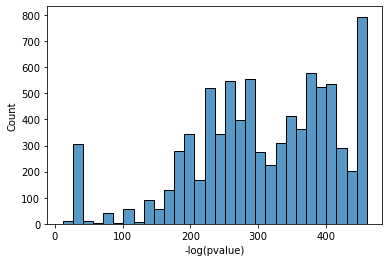

In [17]:
sns.histplot(new_pos['-log(pvalue)'])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


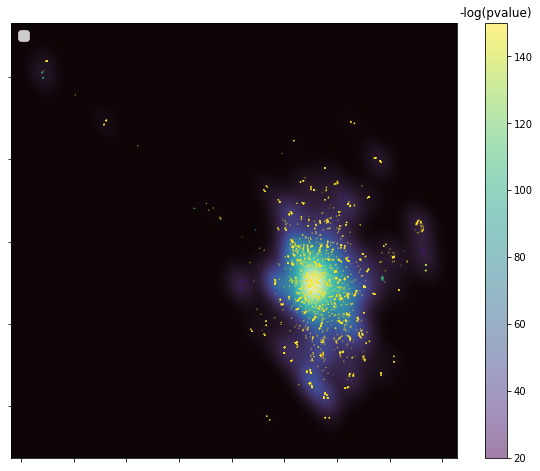

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100, ax=ax)
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.5)
#ax.scatter(rna_pos.values[:, 0], rna_pos.values[:, 1], s=1, c='r', marker='x', label='RNAseq')

ax.set_xticklabels([])
ax.set_yticklabels([])
clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=14)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])

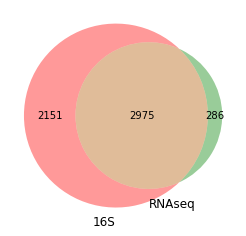

In [19]:
venn2([set(amp_pos.index), set(rna_pos.index)], ['16S', 'RNAseq'])

In [20]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
#wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

# Big venn diagram

In [21]:
rna_comps = rna_compounds[['Name', 'Compound']]
amp_comps = amp_compounds[['Name', 'Compound']]
all_comps = pd.merge(rna_comps, amp_comps, left_on='Compound', right_on='Compound', how='outer')
all_comps = all_comps.dropna().drop_duplicates()
all_comps['num_compounds'] = 1
all_comps = all_comps.rename(columns={'Name_x': 'Human pathways', 'Name_y': 'Microbial pathways'})
all_comps = all_comps.groupby(['Human pathways', 'Microbial pathways']).sum().reset_index()
sub_comps = all_comps.loc[all_comps['num_compounds'] >= 20]

sub_comps['Human pathways'] = sub_comps['Human pathways'].apply(
    lambda x: x.replace(' - Homo sapiens (human)', ''))

all_mat = pd.pivot(data=sub_comps, index='Human pathways', columns='Microbial pathways', 
                   values='num_compounds').fillna(0)

<ipython-input-21-024b2ef0c36f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_comps['Human pathways'] = sub_comps['Human pathways'].apply(


In [22]:
all_mat = all_mat.sort_index().T.sort_index()

In [23]:
sub_comps.sort_values('num_compounds', ascending=False).head(10)

,Human pathways,Microbial pathways,num_compounds
13174,Porphyrin and chlorophyll metabolism,Porphyrin and chlorophyll metabolism,143
0,ABC transporters,ABC transporters,138
9954,Metabolism of xenobiotics by cytochrome P450,Metabolism of xenobiotics by cytochrome P450,121
1093,Amino sugar and nucleotide sugar metabolism,Amino sugar and nucleotide sugar metabolism,108
4702,Drug metabolism - cytochrome P450,Drug metabolism - cytochrome P450,100
15378,Steroid hormone biosynthesis,Steroid hormone biosynthesis,99
13932,Purine metabolism,Purine metabolism,95
16681,Tryptophan metabolism,Tryptophan metabolism,83
10516,"Neomycin, kanamycin and gentamicin biosynthesis","Neomycin, kanamycin and gentamicin biosynthesis",81
3176,Chemical carcinogenesis - DNA adducts,Chemical carcinogenesis - DNA adducts,81


In [24]:
sub_comps.to_csv('../results/compound_subset.csv')

In [25]:
idx = sub_comps['Human pathways'] != sub_comps['Microbial pathways']
sub_comps.loc[idx]

,Human pathways,Microbial pathways,num_compounds
1119,Amino sugar and nucleotide sugar metabolism,O-Antigen nucleotide sugar biosynthesis,47
1201,Aminoacyl-tRNA biosynthesis,Protein digestion and absorption,21
1699,Arachidonic acid metabolism,Serotonergic synapse,32
1977,Ascorbate and aldarate metabolism,Pentose and glucuronate interconversions,23
3188,Chemical carcinogenesis - DNA adducts,Metabolism of xenobiotics by cytochrome P450,40
5329,Fatty acid elongation,Fatty acid degradation,29
7020,Glyoxylate and dicarboxylate metabolism,Carbon fixation pathways in prokaryotes,22
8525,Inositol phosphate metabolism,Phosphatidylinositol signaling system,23
9949,Metabolism of xenobiotics by cytochrome P450,Chemical carcinogenesis - DNA adducts,40
12343,Pentose and glucuronate interconversions,Ascorbate and aldarate metabolism,23


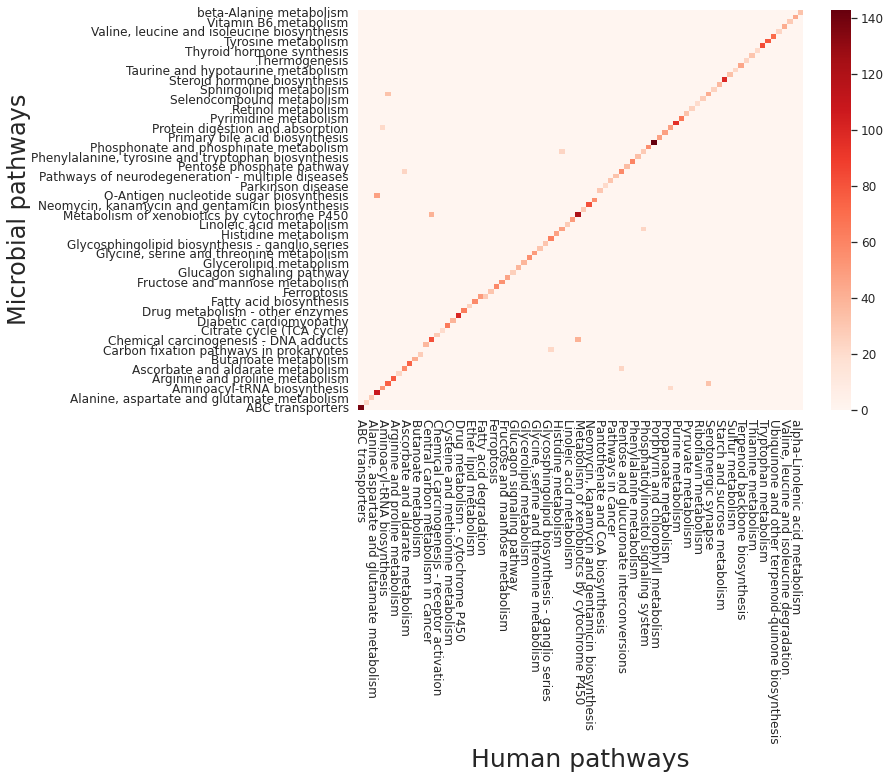

In [26]:
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
#with plt.style.context('dark_background'):

fig, ax = plt.subplots(figsize=(13, 11))
g = sns.heatmap(all_mat.iloc[::-1, :], ax=ax, cbar=True, cmap='Reds')
ax.tick_params(axis='x', labelrotation = 270)
ax.set_ylabel('Microbial pathways', rotation=90, labelpad=0, fontsize=24)
ax.set_xlabel('Human pathways', fontsize=25)
plt.tight_layout()
#_ = ax.set_xticklabels(g.get_xticks(), rotation = 45)

In [ ]:
pwy_pairs = sub_comps.reset_index()
del pwy_pairs['index']
pwy_pairs.to_csv('../results/supplemental_tables/Table_S6.csv')

In [28]:
g.get_xticklabels()

[Text(0.5, 0, 'ABC transporters'),
 Text(2.5, 0, 'Alanine, aspartate and glutamate metabolism'),
 Text(4.5, 0, 'Aminoacyl-tRNA biosynthesis'),
 Text(6.5, 0, 'Arginine and proline metabolism'),
 Text(8.5, 0, 'Ascorbate and aldarate metabolism'),
 Text(10.5, 0, 'Butanoate metabolism'),
 Text(12.5, 0, 'Central carbon metabolism in cancer'),
 Text(14.5, 0, 'Chemical carcinogenesis - receptor activation'),
 Text(16.5, 0, 'Cysteine and methionine metabolism'),
 Text(18.5, 0, 'Drug metabolism - cytochrome P450'),
 Text(20.5, 0, 'Ether lipid metabolism'),
 Text(22.5, 0, 'Fatty acid degradation'),
 Text(24.5, 0, 'Ferroptosis'),
 Text(26.5, 0, 'Fructose and mannose metabolism'),
 Text(28.5, 0, 'Glucagon signaling pathway'),
 Text(30.5, 0, 'Glycerolipid metabolism'),
 Text(32.5, 0, 'Glycine, serine and threonine metabolism'),
 Text(34.5, 0, 'Glycosphingolipid biosynthesis - ganglio series'),
 Text(36.5, 0, 'Histidine metabolism'),
 Text(38.5, 0, 'Linoleic acid metabolism'),
 Text(40.5, 0, 'Metabo

<AxesSubplot:ylabel='Microbial pathways'>

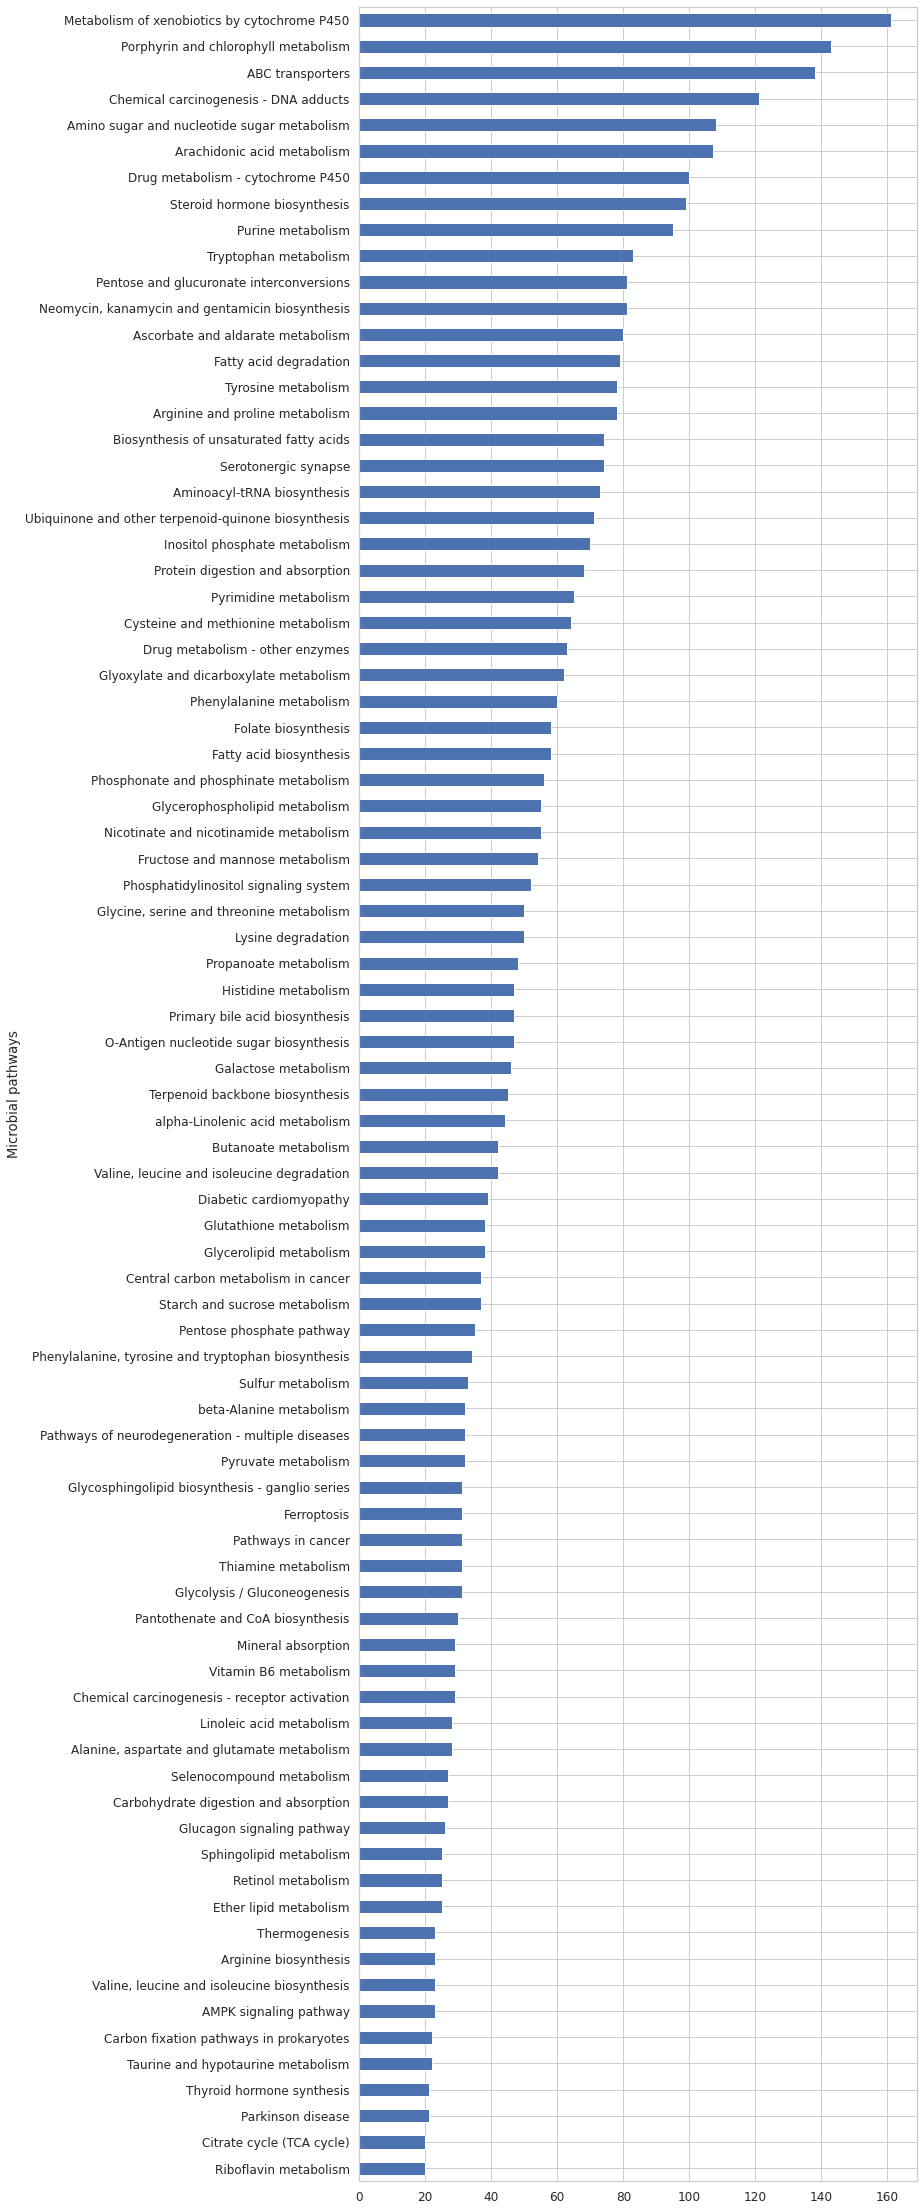

In [29]:
fig, ax = plt.subplots(figsize=(10, 40))
all_mat.sum(axis=1).sort_values().plot.barh(ax=ax)

<AxesSubplot:ylabel='Human pathways'>

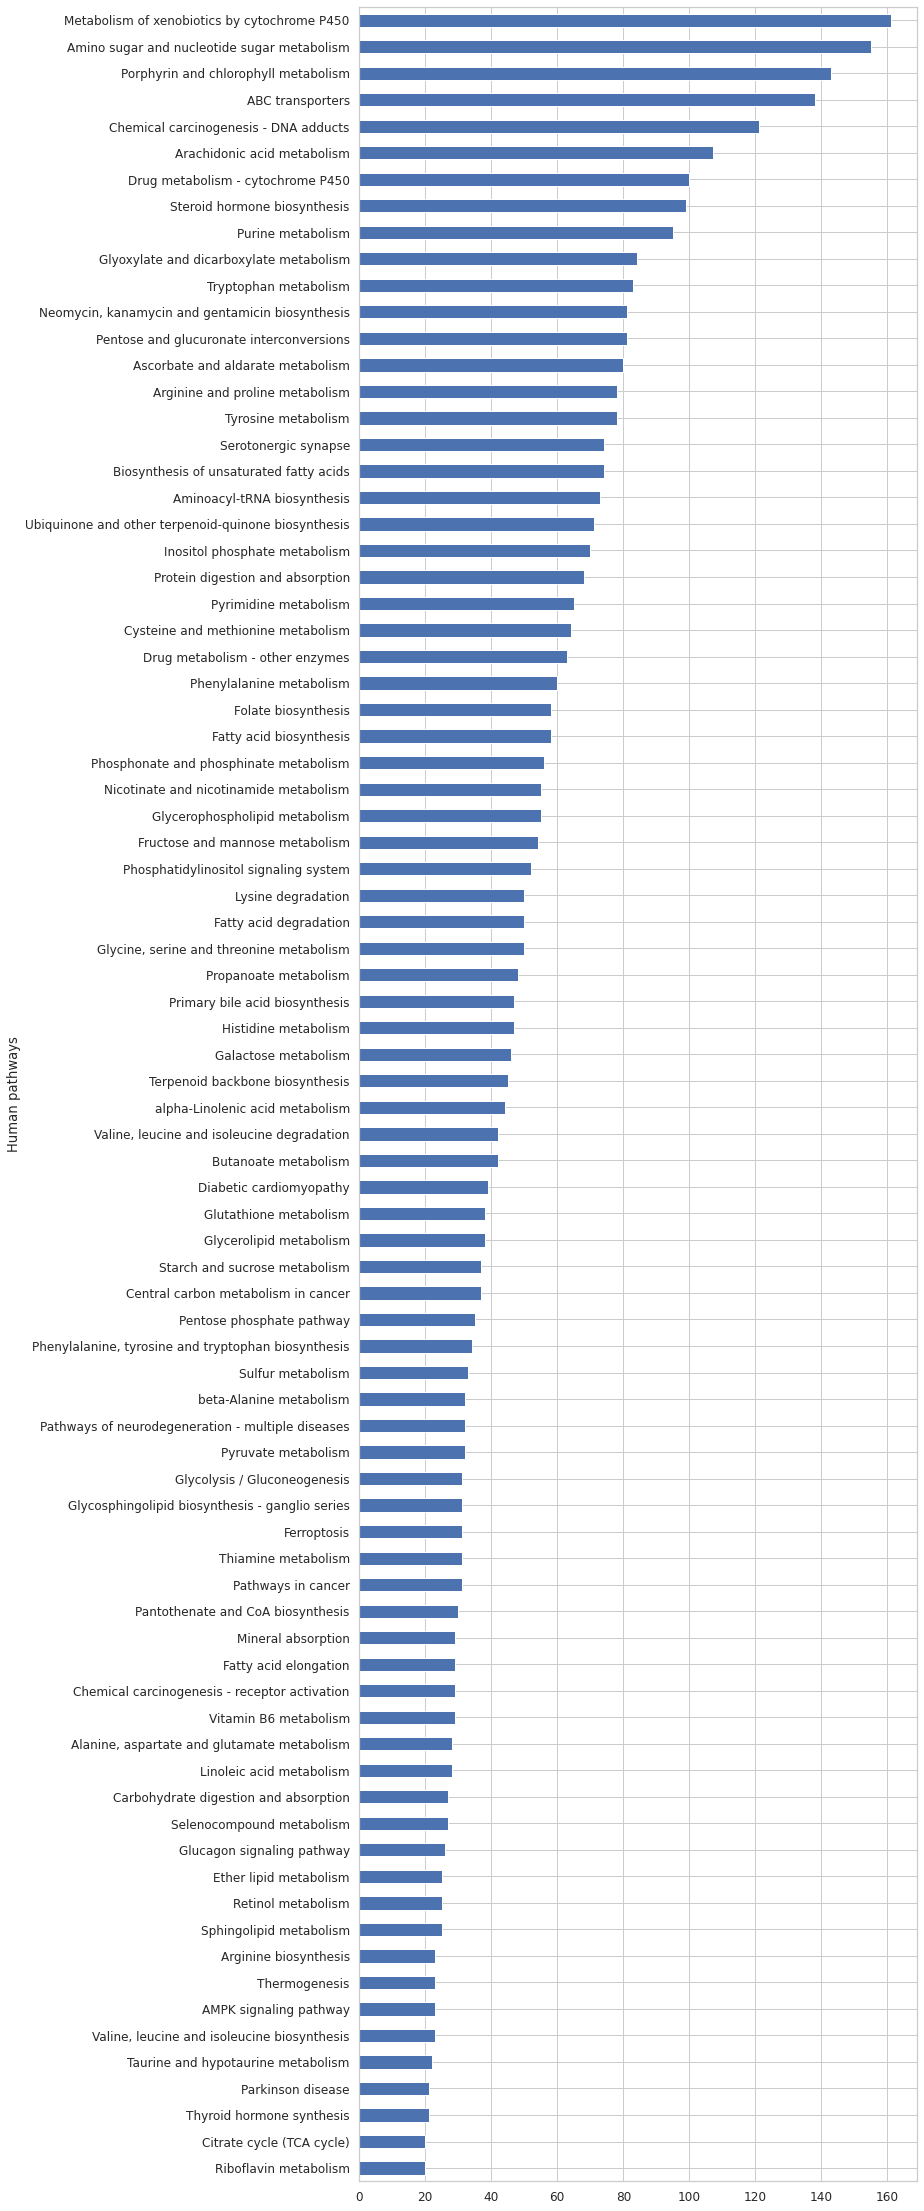

In [30]:
fig, ax = plt.subplots(figsize=(10, 40))
all_mat.sum(axis=0).sort_values().plot.barh(ax=ax)

Higher level information

In [31]:
rna_comps = rna_compounds.sort_values('Name')[['Name', 'Compound']]
amp_comps = amp_compounds.sort_values('Name')[['Name', 'Compound']]
all_comps = pd.merge(rna_comps, amp_comps, left_on='Compound', right_on='Compound', how='outer')
all_comps = all_comps.dropna().drop_duplicates()
all_comps['value'] = 1
all_comps = all_comps.rename(columns={'Name_x': 'Human pathways', 'Name_y': 'Microbial pathways'})
all_comps = all_comps.groupby(['Human pathways', 'Microbial pathways']).sum().reset_index()

In [32]:
all_comps

,Human pathways,Microbial pathways,value
0,ABC transporters - Homo sapiens (human),ABC transporters,138
1,ABC transporters - Homo sapiens (human),AMPK signaling pathway,1
2,ABC transporters - Homo sapiens (human),"Alanine, aspartate and glutamate metabolism",4
3,ABC transporters - Homo sapiens (human),Alcoholism,2
4,ABC transporters - Homo sapiens (human),Alzheimer disease,2
...,...,...,...
17991,mTOR signaling pathway - Homo sapiens (human),Toxoplasmosis,1
17992,mTOR signaling pathway - Homo sapiens (human),"Valine, leucine and isoleucine biosynthesis",1
17993,mTOR signaling pathway - Homo sapiens (human),"Valine, leucine and isoleucine degradation",1
17994,mTOR signaling pathway - Homo sapiens (human),Yersinia infection,1


In [33]:
all_mat = pd.pivot(data=all_comps, index='Human pathways', columns='Microbial pathways', values='value').fillna(0)

<AxesSubplot:xlabel='Microbial pathways', ylabel='Human pathways'>

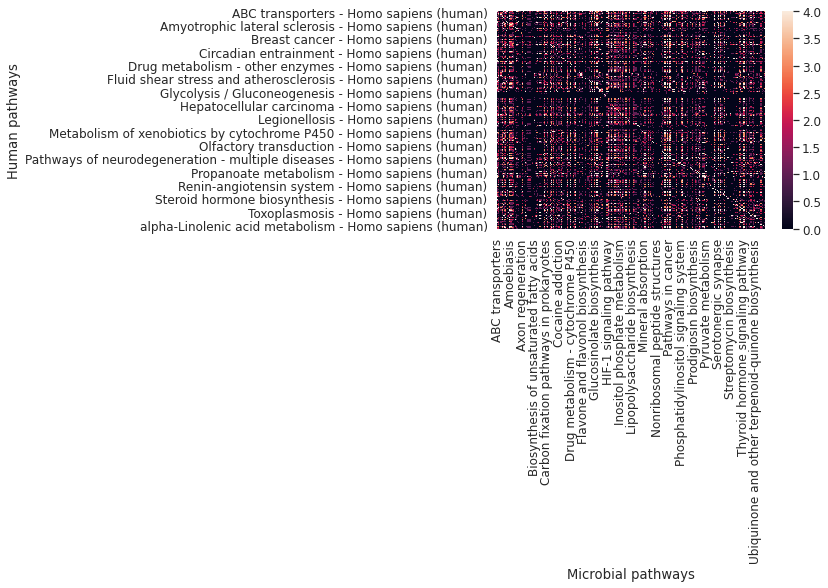

In [34]:
sns.heatmap(all_mat, robust=True)

In [35]:
rna_comps = rna_compounds.sort_values('Name')
amp_comps = amp_compounds.sort_values('Name')
all_comps = pd.merge(rna_comps, amp_comps, left_on='Compound', right_on='Compound', how='outer')

Plot overlap between human and microbial compounds

In [36]:
rna_asd_comps = rna_compounds.loc[rna_compounds['class'] == 'ASD-associated']
rna_con_comps = rna_compounds.loc[rna_compounds['class'] == 'control-associated']

amp_asd_comps = amp_compounds.loc[amp_compounds['class'] == 'ASD-associated']
amp_con_comps = amp_compounds.loc[amp_compounds['class'] == 'control-associated']

comp_df_list = [amp_asd_comps, amp_con_comps, rna_asd_comps, rna_con_comps]
mat = np.zeros((4, 4))
for i, comp_df in enumerate(comp_df_list):
    for j, comp_df2 in enumerate(comp_df_list):
        mat[i, j] = len(set(comp_df['Compound']) & set(comp_df2['Compound']))
col_names = ['Microbe (ASD)', 'Microbe (Control)', 'Human (ASD)', 'Human (Control)']
mat = pd.DataFrame(mat, columns=col_names, index=col_names)

<AxesSubplot:>

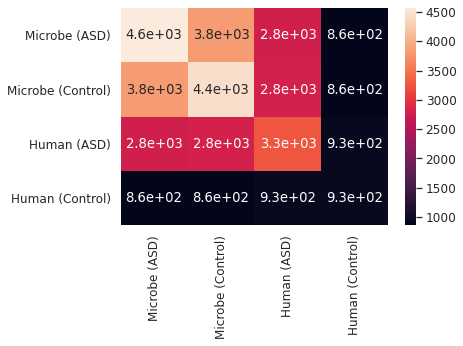

In [37]:
sns.heatmap(mat, annot=True)

# Network plot

In [38]:
rna_compounds.loc[rna_compounds['class'] == 'control-associated'].Name.value_counts().head(50)

Neuroactive ligand-receptor interaction - Homo sapiens (human)                572
Neutrophil extracellular trap formation - Homo sapiens (human)                273
Alcoholism - Homo sapiens (human)                                             210
Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)      192
ABC transporters - Homo sapiens (human)                                       138
Taste transduction - Homo sapiens (human)                                      99
Pathways in cancer - Homo sapiens (human)                                      93
Serotonergic synapse - Homo sapiens (human)                                    84
Alzheimer disease - Homo sapiens (human)                                       80
Arginine and proline metabolism - Homo sapiens (human)                         78
Tyrosine metabolism - Homo sapiens (human)                                     78
Retrograde endocannabinoid signaling - Homo sapiens (human)                    76
cAMP signaling p

In [39]:
rna_compounds.Name.value_counts().head(50)

Pathways in cancer - Homo sapiens (human)                                   5022
Neuroactive ligand-receptor interaction - Homo sapiens (human)              4680
Bile secretion - Homo sapiens (human)                                       3306
Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)    2784
Purine metabolism - Homo sapiens (human)                                    2375
Metabolism of xenobiotics by cytochrome P450 - Homo sapiens (human)         2299
Drug metabolism - cytochrome P450 - Homo sapiens (human)                    2000
ABC transporters - Homo sapiens (human)                                     1932
Diabetic cardiomyopathy - Homo sapiens (human)                              1521
cAMP signaling pathway - Homo sapiens (human)                               1450
Chemical carcinogenesis - DNA adducts - Homo sapiens (human)                1377
Arachidonic acid metabolism - Homo sapiens (human)                          1350
Chemical carcinogenesis - re

In [40]:
nucleotide = ['Amino sugar and nucleotide sugar metabolism', 
              'Pyrimidine metabolism', 'Purine metabolism']
amino_acid = ['Arginine and proline metabolism',
              'Phenylalanine metabolism', 
              'Tyrosine metabolism', 
              'Lysine degradation',
              'Glycine, serine and threonine metabolism',
              'Histidine metabolism',
              'Valine, leucine and isoleucine degradation',
              'Cysteine and methionine metabolism']
carbohydrate = ['Fructose and mannose metabolism', 
                'Glyoxylate and dicarboxylate metabolism',
                'Fatty acid degradation',
                'Starch and sucrose metabolism',
                'Pentose phosphate pathway',
                'Propanoate metabolism',
                'Butanoate metabolism',
                'Nicotinate and nicotinamide metabolism']
lipid = ['Glycerolipid metabolism', 'Glycerophospholipid metabolism']

In [41]:
def wgs_pathway_f(x):
    if x['Name'] in nucleotide:
        return 'Nucleotide\nmetabolism'
    if x['Name'] in amino_acid:
        return 'Amino acid\nmetabolism'
    if x['Name'] in carbohydrate:
        return 'Carbohydrate\nmetabolism'
    if ('lipid' in x['Name'] or 'Lipid' in x['Name']) and 'metabolism' in x['Name']:
        return 'Lipid\nmetabolism'
amp_compounds['Pathway_name'] = amp_compounds.apply(wgs_pathway_f, axis=1)

In [42]:
amp_compounds['Pathway_name'].value_counts()

Nucleotide\nmetabolism      21267
Carbohydrate\nmetabolism    18719
Amino acid\nmetabolism      18084
Lipid\nmetabolism            3041
Name: Pathway_name, dtype: int64

In [43]:
human_pathways = ['Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)',
                  'Fatty acid degradation - Homo sapiens (human)',
                  'Tryptophan metabolism - Homo sapiens (human)',
                  'Purine metabolism - Homo sapiens (human)',
                  'Bile secretion - Homo sapiens (human)',
                  'Carbohydrate digestion and absorption - Homo sapiens (human)']


def human_pathway_f(x):
    if x['Name'] == 'Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)':
        return 'Neuro-\ndegeneration'
    if x['Name'] == 'Fatty acid degradation - Homo sapiens (human)':
        return 'Fatty acid \ndegradation'
    if x['Name'] == 'Tryptophan metabolism - Homo sapiens (human)':
        return 'Tryptophan\nmetabolism'
    #if x['Name'] == 'Bile secretion - Homo sapiens (human)':
    #    return 'Bile \n secretion'
    if x['Name'] == 'Purine metabolism - Homo sapiens (human)':
        return 'Purine\nmetabolism'
    if x['Name'] == 'Carbohydrate digestion and absorption - Homo sapiens (human)':
        return 'Carbohydrate\ndigestion\nand absorption'
rna_compounds['Pathway_name'] = rna_compounds.apply(human_pathway_f, axis=1)

In [44]:
# remove redundancy
new_pos = new_pos.reset_index().groupby('index').max()

In [45]:
cmap = plt.get_cmap('Greens')

amp_attr = {
    'Nucleotide\nmetabolism': {'dx': 0, 'dy': 0.2, 'color': cmap(0.7)},
    'Carbohydrate\nmetabolism': {'dx': -0.55, 'dy': -0.1, 'color': cmap(0.8)},
    'Amino acid\nmetabolism': {'dx': 0.15, 'dy': -0.35, 'color': cmap(0.9)},
    'Lipid\nmetabolism': {'dx': -0.2, 'dy': 0.2, 'color': cmap(1.0)}
}

cmap = plt.get_cmap('YlOrBr')
rna_attr = {
    'Neuro-\ndegeneration': {'dx': 0.2, 'dy': -0.1, 'color': cmap(0.6)},
    'Fatty acid \ndegradation': {'dx': -0.4, 'dy': -0.35, 'color': cmap(0.9)},
    'Tryptophan\nmetabolism': {'dx': -0.15, 'dy': -0.3, 'color': cmap(0.7)},
    'Purine\nmetabolism': {'dx': 0.2, 'dy': 0.1, 'color': cmap(0.5)},
    'Carbohydrate\ndigestion\nand absorption': {'dx': -0.5, 'dy': -0, 'color': cmap(1.0)}
}

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


(-0.9, 0.4, -0.9, 0.4)

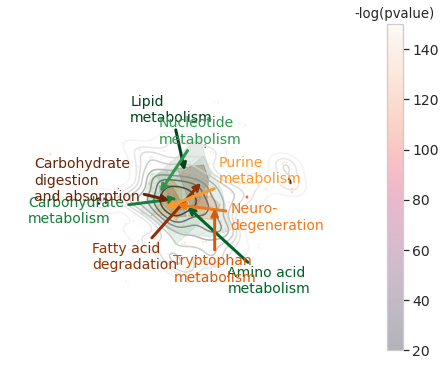

In [46]:
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches 

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], 
            cmap='Greys', fill=False, thresh=0, levels=10, ax=ax)

for name, df in amp_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = amp_attr[name]['dx'], amp_attr[name]['dy'], amp_attr[name]['color']
    #ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.1)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
for name, df in rna_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    compounds = list(set(compounds) & set(new_pos.index))
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = rna_attr[name]['dx'], rna_attr[name]['dy'], rna_attr[name]['color']
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.2)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.3)

clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=16)

#ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlim([-0.9, 0.4])
ax.set_ylim([-0.9, 0.4])
ax.get_legend().remove()
clb.ax.tick_params(labelsize=14) 
fig.patch.set_visible(False)
ax.axis('off')